In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import pickle

## Time-dependent, no periodic component

In [31]:
# from utils.train_synthetic import train_conformal_forecaster
time_dependent_results = train_conformal_forecaster(noise_mode='time-dependent')

**Joint coverage**

In [32]:
for result in time_dependent_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

92.0\%
91.6\%
92.0\%
92.2\%
91.2\%


**Independent coverage**

In [33]:
for result in time_dependent_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9600, 0.9840, 0.9820, 0.9940, 0.9820])
[96.0\%, 99.4\%]

tensor([0.9840, 0.9880, 0.9840, 0.9560, 0.9840])
[95.6\%, 98.8\%]

tensor([0.9820, 0.9820, 0.9720, 0.9760, 0.9780])
[97.2\%, 98.2\%]

tensor([0.9800, 0.9800, 0.9740, 0.9920, 0.9840])
[97.4\%, 99.2\%]

tensor([0.9780, 0.9800, 0.9900, 0.9780, 0.9800])
[97.8\%, 99.0\%]



**Mean absolute error**

In [34]:
for result in time_dependent_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([2.3385, 3.1437, 3.7521, 4.0304, 4.2055], grad_fn=<MeanBackward1>)
3.49 \(\pm\) 2.69

tensor([2.8506, 3.5456, 4.1636, 4.6017, 4.7974], grad_fn=<MeanBackward1>)
3.99 \(\pm\) 3.13

tensor([3.9038, 4.5945, 5.0242, 5.6742, 5.4950], grad_fn=<MeanBackward1>)
4.94 \(\pm\) 3.79

tensor([4.3761, 5.1412, 6.1135, 5.9675, 6.7823], grad_fn=<MeanBackward1>)
5.68 \(\pm\) 4.35

tensor([5.4778, 6.2312, 7.0181, 7.4857, 7.7957], grad_fn=<MeanBackward1>)
6.80 \(\pm\) 5.33



**Interval widths**

In [35]:
for result in time_dependent_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([12.8132, 17.8813, 21.2491, 23.2933, 23.6637], requires_grad=True)
tensor(19.7801, grad_fn=<MeanBackward0>) tensor(4.5201, grad_fn=<StdBackward0>)

tensor([17.1109, 20.6710, 22.1549, 23.8422, 27.9436], requires_grad=True)
tensor(22.3445, grad_fn=<MeanBackward0>) tensor(3.9944, grad_fn=<StdBackward0>)

tensor([22.0895, 25.7180, 28.0620, 32.3142, 33.7863], requires_grad=True)
tensor(28.3940, grad_fn=<MeanBackward0>) tensor(4.7818, grad_fn=<StdBackward0>)

tensor([25.1534, 29.1088, 32.5214, 39.1727, 41.6589], requires_grad=True)
tensor(33.5230, grad_fn=<MeanBackward0>) tensor(6.8675, grad_fn=<StdBackward0>)

tensor([31.4864, 34.9797, 43.5343, 42.1337, 47.7705], requires_grad=True)
tensor(39.9809, grad_fn=<MeanBackward0>) tensor(6.6164, grad_fn=<StdBackward0>)



## Static noise, no periodic component

In [174]:
static_results = train_conformal_forecaster(noise_mode='static')

**Joint coverage**

In [175]:
for result in static_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

93.4\%
95.2\%
94.0\%
93.4\%
95.0\%


**Independent coverage**

In [176]:
for result in static_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9800, 0.9720, 0.9600, 0.9840, 0.9860])
[96.0\%, 98.6\%]

tensor([0.9820, 0.9820, 0.9920, 0.9800, 0.9840])
[98.0\%, 99.2\%]

tensor([0.9840, 0.9760, 0.9920, 0.9860, 0.9820])
[97.6\%, 99.2\%]

tensor([0.9840, 0.9740, 0.9740, 0.9780, 0.9800])
[97.4\%, 98.4\%]

tensor([0.9760, 0.9820, 0.9800, 0.9820, 0.9760])
[97.6\%, 98.2\%]



**Mean absolute error**

In [177]:
for result in static_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([2.0872, 2.9400, 3.5203, 3.9272, 4.1159], grad_fn=<MeanBackward1>)
3.32 \(\pm\) 2.64

tensor([1.8089, 2.6188, 3.2409, 3.6305, 3.8306], grad_fn=<MeanBackward1>)
3.03 \(\pm\) 2.49

tensor([1.9565, 2.6556, 3.3701, 3.8385, 4.0479], grad_fn=<MeanBackward1>)
3.17 \(\pm\) 2.51

tensor([1.9175, 2.6714, 3.2163, 3.7312, 3.7828], grad_fn=<MeanBackward1>)
3.06 \(\pm\) 2.45

tensor([1.9798, 2.7544, 3.3348, 3.8711, 4.1161], grad_fn=<MeanBackward1>)
3.21 \(\pm\) 2.65



**Interval widths**

In [178]:
for result in static_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([11.4049, 15.6011, 18.4794, 21.4902, 22.7816], requires_grad=True)
tensor(17.9514, grad_fn=<MeanBackward0>) tensor(4.5966, grad_fn=<StdBackward0>)

tensor([11.3676, 15.2927, 20.2274, 21.7256, 22.5205], requires_grad=True)
tensor(18.2268, grad_fn=<MeanBackward0>) tensor(4.7523, grad_fn=<StdBackward0>)

tensor([11.8162, 15.4993, 19.1731, 21.7291, 22.6258], requires_grad=True)
tensor(18.1687, grad_fn=<MeanBackward0>) tensor(4.5009, grad_fn=<StdBackward0>)

tensor([11.9010, 14.8107, 18.2220, 20.3336, 21.5495], requires_grad=True)
tensor(17.3634, grad_fn=<MeanBackward0>) tensor(3.9824, grad_fn=<StdBackward0>)

tensor([11.6268, 15.8042, 19.8905, 22.2562, 23.6211], requires_grad=True)
tensor(18.6398, grad_fn=<MeanBackward0>) tensor(4.9163, grad_fn=<StdBackward0>)



## Periodic component, time dependent noise

In [179]:
periodic_results = train_conformal_forecaster(noise_mode='periodic')

**Joint coverage**

In [180]:
for result in periodic_results:
    print('{:.1f}\\%'.format(result['Mean joint coverage'] * 100))

93.6\%
90.8\%


**Independent coverage**

In [181]:
for result in periodic_results:
    independent_coverages = result['Mean independent coverage']
    print(independent_coverages)
#     print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(independent_coverages.mean() * 100, independent_coverages.std() * 100))
    print('[{:.1f}\\%, {:.1f}\\%]'.format(independent_coverages.min() * 100, independent_coverages.max() * 100))
    print()

tensor([0.9800, 0.9880, 0.9840, 0.9940, 0.9860, 0.9980, 0.9940, 0.9960, 0.9960,
        0.9840])
[98.0\%, 99.8\%]

tensor([0.9920, 0.9900, 0.9880, 0.9880, 0.9980, 0.9820, 0.9900, 0.9820, 0.9880,
        0.9860])
[98.2\%, 99.8\%]



**Mean absolute error**

In [182]:
for result in periodic_results:
    errors = result['Errors']
    print(errors.mean(axis=0)) 
#     print(errors.mean())
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(errors.mean(), errors.std()))
    print()

tensor([ 9.2719,  8.7163, 11.2114, 10.9359, 12.1758, 12.1385, 14.2406, 13.7489,
        14.9719, 14.9102], grad_fn=<MeanBackward1>)
12.23 \(\pm\) 9.45

tensor([13.7796, 14.7361, 16.0265, 16.0010, 16.5716, 17.8106, 18.4755, 19.6435,
        19.2586, 19.6999], grad_fn=<MeanBackward1>)
17.20 \(\pm\) 13.22



**Interval widths**

In [183]:
for result in periodic_results:
    print(result['Mean confidence interval widths'])
    print(result['Mean confidence interval widths'].mean(), result['Mean confidence interval widths'].std())
    print()

tensor([59.7701, 61.1170, 70.0357, 74.4743, 79.0557, 87.5056, 93.0214, 92.5021,
        95.7963, 95.7216], requires_grad=True)
tensor(80.9000, grad_fn=<MeanBackward0>) tensor(14.0132, grad_fn=<StdBackward0>)

tensor([ 84.4764,  97.2791, 108.4707, 103.8025, 110.0651, 112.0813, 118.9014,
        116.7674, 112.3318, 127.5560], requires_grad=True)
tensor(109.1732, grad_fn=<MeanBackward0>) tensor(11.9731, grad_fn=<StdBackward0>)



## Plotting

In [38]:
import pickle

In [184]:
def plot_timeseries(noise_mode, baseline, index=None, forecast_only=False, figsize=(28,4), figure_name=None):
     
    plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    plt.rcParams.update({'axes.titlesize': 16})
    
    datasets = []
    for i in ([2, 10] if noise_mode == 'periodic' else range(1, 6)):
        with open('processed_data/synthetic_{}_raw_{}.pkl'.format(noise_mode, i), 'rb') as f:
            datasets.append(pickle.load(f))
        
    with open('saved_results/{}_{}.pkl'.format(noise_mode, baseline), 'rb') as f:
        all_results = pickle.load(f)
        
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=figsize, sharey=True)

    for j, ax in enumerate(axs.flat):
        _, _, dataset = datasets[j]
        results = all_results[j]
        
        X, Y = dataset
            
        if index is None:
            index = range(len(X))
        i = np.random.choice(index)

        
        # Derive unpadded sequences and targets
        sequence, target = X[i], Y[i]
        
        horizon = len(target)
        length = len(sequence)
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        upper_limit = results['Upper limit']
        lower_limit = results['Lower limit']
        
        lower = [sequence[-1].item()] + lower_limit[i].flatten().tolist()
        upper = [sequence[-1].item()] + upper_limit[i].flatten().tolist()
        preds = [sequence[-1].item()] + results['Point predictions'][i].flatten().tolist()

        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), preds, linestyle="--", linewidth=3, color="r")

#         if j == 0:
#             ax.set(ylabel='Prediction')  
        ax.set(xlabel='Time step')
        if noise_mode == 'time-dependent':
            ax.set(title='$\sigma_t^2 =${:.1f}$t$'.format((j+1)*0.1))
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.4)
    
#     plt.xlabel('Time step')
#     plt.ylabel('Prediction')
    if figure_name is not None:
        plt.savefig('{}.png'.format(figure_name) , bbox_inches='tight')
    plt.show()

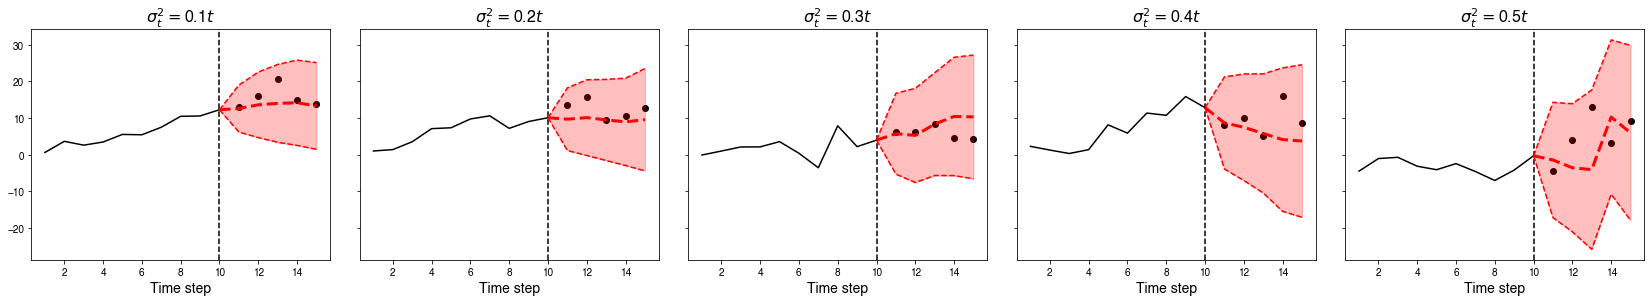

In [152]:
plot_timeseries(noise_mode='time-dependent', baseline='CPRNN', figure_name='time-dependent')

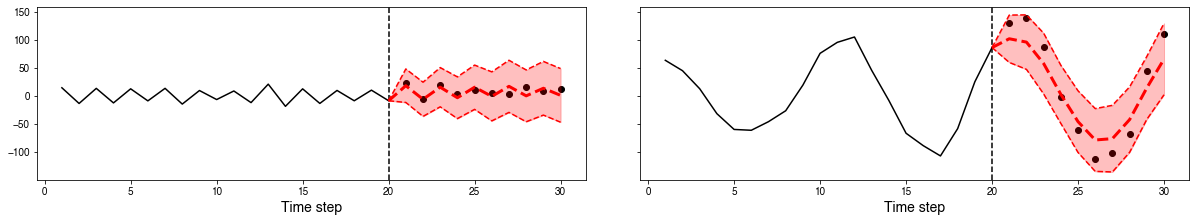

In [194]:
plot_timeseries(noise_mode='periodic', baseline='CPRNN', figsize=(20,3), figure_name='periodic')

## Long horizon analysis

In [2]:
from utils.data_processing_synthetic import get_synthetic_splits
get_synthetic_splits(length=20, n_calibration=10000, conformal=True, cached=False)

[(<utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd591e088d0>,
  <utils.data_processing_synthetic.AutoregressiveForecastDataset at 0x7fd58f971f90>)]

In [33]:
from utils.train_synthetic import train_conformal_forecaster
_ = train_conformal_forecaster(noise_mode='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='GRU')

Epoch: 0	Train loss: 92.09859313964844
Epoch: 50	Train loss: 8.682822608947754
Epoch: 100	Train loss: 8.540002632141114
Epoch: 150	Train loss: 8.491893529891968
Epoch: 200	Train loss: 8.490971851348878
Epoch: 250	Train loss: 8.495005989074707
Epoch: 300	Train loss: 8.500922393798827
Epoch: 350	Train loss: 8.490542697906495
Epoch: 400	Train loss: 8.49884033203125
Epoch: 450	Train loss: 8.491770839691162
Epoch: 500	Train loss: 8.490327453613281
Epoch: 550	Train loss: 8.497047901153564
Epoch: 600	Train loss: 8.493861103057862
Epoch: 650	Train loss: 8.49359712600708
Epoch: 700	Train loss: 8.488061046600341
Epoch: 750	Train loss: 8.487854957580566
Epoch: 800	Train loss: 8.495618152618409
Epoch: 850	Train loss: 8.48921251296997
Epoch: 900	Train loss: 8.4827410697937
Epoch: 950	Train loss: 8.488468837738036


In [34]:
import torch
model = torch.load('saved_models/long-horizon_CPRNN_GRU_100.pt')

In [35]:
import numpy as np

In [53]:
widths = []
alphas = np.arange(100) * 0.01
for alpha in alphas:
    corrected_alpha = alpha / model.horizon
    corrected_critical_calibration_scores = torch.tensor([[
            torch.quantile(
                position_calibration_scores,
                q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
            for position_calibration_scores in feature_calibration_scores]
            for feature_calibration_scores in model.calibration_scores]).T
    widths.append(corrected_critical_calibration_scores.flatten().tolist())
widths = np.array(widths)
widths = widths * 2

Low to high allowed error rate (high to low coverage): intervals get narrower when lower coverage is required

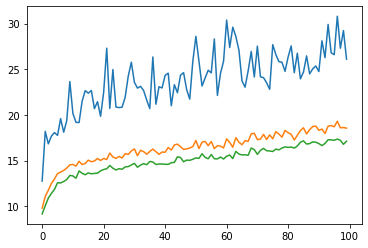

In [55]:
import matplotlib.pyplot as plt
plt.plot(widths[0])
plt.plot(widths[49])
plt.plot(widths[99])

In [75]:
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/long-horizon_CPRNN_{}_100.pt'.format(rnn_model))
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [118]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

In [127]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({'axes.labelsize': 12,
                     'axes.titlesize': 12})

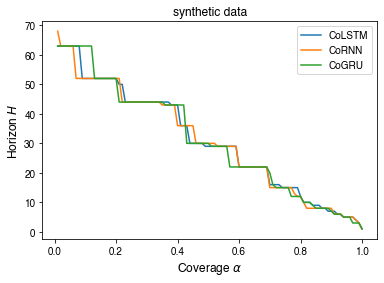

In [129]:
threshold_width = 15
for threshold_width in [16]:
    valid_horizons = compute_valid_horizons(threshold_width)
    for rnn_model in valid_horizons.keys():
        plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.show()